# Default on credit card prediction (SVM) 

Let's introduce at first the dataset that would be used in this mini-project. (You'll find the source at the Read-me of the repo). 

So let's visualize this dataset and define attributes as we go on. 

In [35]:
import numpy as np
import pandas as pd
from sklearn import svm, datasets
from pylab import *

In [96]:
input_file = "C:/Users/YsfEss/Desktop/UCI_Credit_Card.csv"
df = pd.read_csv(input_file, header = 0)
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


There is 25 attributes for each client, but we will be interested in particular in 12 attributes (11 predictors & 1 output) for building our model. The features used for the rest of this tutorial are: 


**1- ID: ID of each client** (Won't be used as feature obviously, I left it for visualization purposes only)

**2- LIMIT_BAL: Amount of given credit in NT dollars**

**3- SEX: Gender (1=male, 2=female)**

**4- EDUCATION: (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)**

**5- MARRIAGE: Marital status (1=married, 2=single, 3=others)**

**6- AGE: Age in years**

for i [0,6]

**(7-12)- PAY_i: Repayment status in i+9 month, 2005 (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, ... 8=payment delay for eight months, 9=payment delay for nine months and above)**

**default.payment.next.month: Default payment (1=yes, 0=no)**


In [97]:
features=df.columns
features=list(features)
features=features[0:12]+[features[len(features)-1]]
df1=df[features]
df1.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,1
1,2,120000.0,2,2,2,26,-1,2,0,0,0,2,1
2,3,90000.0,2,2,2,34,0,0,0,0,0,0,0
3,4,50000.0,2,2,1,37,0,0,0,0,0,0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,0,0,0


Let's make a plot of some of the obseravtion based only on LIMIT_BAL and AGE, just for visualization sake.

It's clear that no pattern is likely to appear using only these two features, but let's just see how data points are spread using these two. 

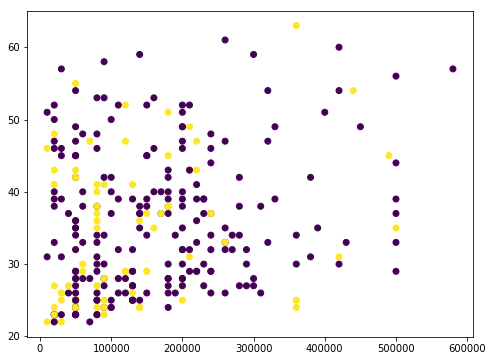

In [98]:
%matplotlib inline
f=df1.sample(frac=0.01)
X=f[['LIMIT_BAL','AGE']]
y=f['default.payment.next.month']
plt.figure(figsize=(8, 6))
plt.scatter(X['LIMIT_BAL'], X['AGE'], c=y.astype(np.float))
plt.show()

Okay, the first big remark we might have just by looking at the dataset is that it needs feature scaling for the qualitative ones, since **LIMIT_BAL** is in tens of thousands scale and the **AGE** is in its own usual range, while the rest of attributes are categorical so there is no problem there. Now we should scale both the quantitative features.

We will mainly devide these attributes by a dispersion  measure standard deviation for example.

In [99]:
mean1=float(np.mean(df1['LIMIT_BAL']))
mean2=float(np.mean(df1['AGE']))

In [100]:
df1['LIMIT_BAL']=df1['LIMIT_BAL']/mean1
df1['AGE']=df1['AGE']/mean2

C:\Users\YsfEss\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\YsfEss\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [101]:
df1.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,default.payment.next.month
0,1,0.119414,2,2,1,0.676333,2,2,-1,-1,-2,-2,1
1,2,0.716485,2,2,2,0.732694,-1,2,0,0,0,2,1
2,3,0.537364,2,2,2,0.958138,0,0,0,0,0,0,0
3,4,0.298535,2,2,1,1.042679,0,0,0,0,0,0,0
4,5,0.298535,1,2,1,1.606290,-1,0,-1,0,0,0,0


Now that we got that out of the way, let's carry on to the train/test data splitting.

This time since I want to focuse more on the confusion matrix, post model generating analysis and handeling the skewed data set, I'll just use the 70/30.

What makes this dataset unbalanced? Well it is only normal that the number of defaulters would be very smaller than the number of non-defaulters, otherways Taiwan Banks are doing something really wrong. 

So let's confirm this hypothesis.

In [102]:
print('The percentage of defaulters in the dataset is: ',100*len(df1.loc[df1['default.payment.next.month']==1])/30000,'%')

The percentage of defaulters in the dataset is:  22.12 %


Not very small portion but still unbalanced.

So let's prepare the two train/test datasets.

In [103]:
dfShuf=df1.sample(frac=1)

In [104]:
train=dfShuf[0:21000]
test=dfShuf[21000:]

In [105]:
DepVar=features[1:len(features)-1]
IndeVar=features[len(features)-1]
X=train[DepVar].to_numpy()
y=train[IndeVar].to_numpy()

In [106]:
len(X)

21000

In [107]:
#Let's start with a linear kernel
svc=svm.SVC(kernel='linear', C=1.0)

In [109]:
model=svc.fit(X,y)

In [ ]:
predictions=